<a href="https://colab.research.google.com/github/shreyasmiraj/exvivo_spine_analysis/blob/main/Spine_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install CFsshTunnel
!pip install XlsxWriter

In [ ]:
import os
import PIL
import scipy
import torch
import pickle
import google
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from getpass import getpass
from base64 import b64encode
from matplotlib import figure
from tqdm.notebook import tqdm
from IPython.display import HTML
from google.colab import userdata
from CFsshTunnel.CFsshTunnel import CFsshTunnel
from CFsshTunnel.utils.utils import keep_alive
from CFsshTunnel.code_server.code_server import launch_codeserver

In [ ]:
_, hostname, user = CFsshTunnel(public_keys=[userdata.get('drsa')])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
glutamate_source_path = '/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/glutamate_stimulation'
control_source_path = '/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/no_stimulation_control'
tree_stim_source_path = '/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/Tree_Spines/stim'
tree_control_source_path = '/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/Tree_Spines/control'

## Spine Data restructuring

In [ ]:
def restructure_data(source_path, write_to_file=True):
  combined_dfs = {}
  timepoints = ['10min', '30min', '60min', '90min', '120min', 'baseline']
  spine_dfs = {'thin':{}, 'mushroom':{}, 'stubby':{}, 'filopodia':{}}

  for directory in os.listdir(source_path):
    path = os.path.join(source_path, directory)
    if os.path.isdir(path):
      xls_file = os.path.join(path, 'Spine Details - Automatic (Backbone length classifier).xlsx')
      if os.path.isfile(xls_file):
        for timepoint in timepoints:
          df = pd.read_excel(xls_file, sheet_name=timepoint)
          df = df.iloc[:-2]
          combined_dfs[timepoint] = combined_dfs.get(timepoint, pd.DataFrame())
          combined_dfs[timepoint] = pd.concat([combined_dfs[timepoint], df])

  for spine in spine_dfs.keys():
    for timepoint in timepoints:
      spine_df = combined_dfs[timepoint][combined_dfs[timepoint]['Spine Type'] == spine]
      spine_dfs[spine][timepoint] = spine_dfs[spine].get(timepoint, pd.DataFrame())
      spine_dfs[spine][timepoint] = pd.concat([spine_dfs[spine][timepoint], spine_df])

  # make new folder for each file type and store there
  if write_to_file:
    combined_path = os.path.join(source_path, 'combined.xlsx')
    writer = pd.ExcelWriter(combined_path, engine = 'xlsxwriter')
    for timepoint in combined_dfs.keys():
      combined_dfs[timepoint].to_excel(writer, sheet_name=timepoint)
    writer.close()

    for spine in spine_dfs.keys():
      spine_path = os.path.join(source_path, spine + '.xlsx')
      writer = pd.ExcelWriter(spine_path, engine = 'xlsxwriter')
      for timepoint in spine_dfs[spine].keys():
        spine_dfs[spine][timepoint].to_excel(writer, sheet_name=timepoint)
      writer.close()
  return combined_dfs, spine_dfs


def merge_timepoints(data, path, quantile_filter=False):
  combined_dfs = {}
  for spine_type, spine_data in data.items():
      merge_spine_data = []
      for parameter in parameters_of_interest:
          timepoint = list(spine_data.keys())[-1]
          data = pd.DataFrame(list(spine_data[timepoint][parameter]), columns=[parameter+'_'+timepoint])
          if quantile_filter:
            IQR = data.quantile(0.75) - data.quantile(0.25)
            data = data[~((data < (data.quantile(0.25) - 1.5 * IQR)) |(data > (data.quantile(0.75) + 1.5 * IQR))).any(axis=1)]
          merge_spine_data.append()
          for timepoint in list(spine_data.keys())[:-1]:
              data = pd.DataFrame(list(spine_data[timepoint][parameter]), columns=[parameter+'_'+timepoint])
              if quantile_filter:
                IQR = data.quantile(0.75) - data.quantile(0.25)
                data = data[~((data < (data.quantile(0.25) - 1.5 * IQR)) |(data > (data.quantile(0.75) + 1.5 * IQR))).any(axis=1)]
              merge_spine_data.append(data)
      combined_dfs[spine_type] = pd.concat(merge_spine_data, axis=1)

  merge_spine_path = os.path.join(path, path.split('_')[-1]+'_merge_spine_data.xlsx')
  if quantile_filter:
    merge_spine_path = os.path.join(path, path.split('_')[-1]+'_IQRfiltered_merge_spine_data.xlsx')
  writer = pd.ExcelWriter(merge_spine_path, engine = 'xlsxwriter')
  print(merge_spine_path)
  for spine_type, spine_data in combined_dfs.items():
    spine_data.to_excel(writer, sheet_name=spine_type)
  writer.close()


def show_distribution(data, parameter, quantile_filter=False):
  for spine in tqdm(data.keys()):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes = axes.ravel()
    for i, timepoint in enumerate(data[spine].keys()):
  # Generate data for each histogram
      if quantile_filter:
        spine_data = pd.DataFrame(data[spine][timepoint][parameter], columns=[parameter])
        IQR = spine_data.quantile(0.75) - spine_data.quantile(0.25)
        spine_data = spine_data[~((spine_data < (spine_data.quantile(0.25) - 1.5 * IQR)) |(spine_data > (spine_data.quantile(0.75) + 1.5 * IQR))).any(axis=1)]
      else:
        spine_data = data[spine][timepoint][parameter]
      axes[i].hist(spine_data, bins=25)
      axes[i].set_xlabel(parameter)
      axes[i].set_ylabel('Frequency')
      axes[i].set_title(timepoint)
  # Adjust spacing and display
    fig.suptitle('Distribution for {} spines'.format(spine), fontsize=30)
    fig.tight_layout()
    plt.show()


def merge_tree_spine(source_path, write_to_file=True):
  density_merge = {'baseline':{}, '10min':{}, '30min':{}, '60min':{}, '90min':{}, '120min':{}}
  quantity_merge = {'baseline':{}, '10min':{}, '30min':{}, '60min':{}, '90min':{}, '120min':{}}

  timepoints = [ 'baseline', '10min', '30min', '60min', '90min', '120min']
  spine_types = {'Spines':0, 'thin':2, 'stubby':3, 'mushroom':4, 'filopodia':5}

  for directory in os.listdir(source_path):
    path = os.path.join(source_path, directory)
    if os.path.isdir(path):
      xls_file = os.path.join(path, 'Tree Spines - Dendrites.xlsx')
      print(xls_file)
      if os.path.isfile(xls_file):
        for timepoint in timepoints:
          df = pd.read_excel(xls_file, sheet_name=timepoint)
          for spine in spine_types.keys():
            if spine not in density_merge[timepoint] or spine not in quantity_merge[timepoint]:
              density_merge[timepoint][spine] = []
              quantity_merge[timepoint][spine] = []
            density_merge[timepoint][spine].append(df['Density(1/µm)'][spines_types[spine]])
            quantity_merge[timepoint][spine].append(df['Qty 1'][spines_types[spine]])


  density_merge = pd.DataFrame(density_merge)
  quantity_merge = pd.DataFrame(quantity_merge)

  combined_dfs = {'number': {}, 'density': {}}

  for spine in spine_types.keys():
    combined_dfs['number'][spine] = combined_dfs['number'].get(spine, pd.DataFrame())
    combined_dfs['density'][spine] = combined_dfs['density'].get(spine, pd.DataFrame())

    for column in density_df.columns.values:
      combined_dfs['density'][spine] = pd.concat([combined_dfs['density'][spine], pd.DataFrame(density_merge[column][spine], columns=[column])], axis=1)
      combined_dfs['number'][spine] = pd.concat([combined_dfs['number'][spine], pd.DataFrame(quantity_merge[column][spine], columns=[column])], axis=1)

  if write_to_file:
    combined_path = os.path.join(source_path, 'combined.xlsx')
    writer = pd.ExcelWriter(combined_path, engine = 'xlsxwriter')
    for spine in spine_types.keys():
      pd.concat([combined_dfs['number'][spine], combined_dfs['density'][spine]], axis=1).to_excel(writer, sheet_name=spine)
    writer.close()

  return combined_dfs

In [ ]:
control_combined_dfs, control_spine_dfs = restructure_data(control_source_path, write_to_file=False)
glu_combined_dfs, glu_spine_dfs = restructure_data(glutamate_source_path, write_to_file=False)

In [ ]:
parameters_of_interest = ['Backbone Length(µm)','Volume(µm³)','Surface Area(µm²)','Head Diameter(µm)']

In [ ]:
merge_timepoints(control_spine_dfs, control_source_path, quantile_filter=True)
merge_timepoints(glu_spine_dfs, glutamate_source_path, quantile_filter=True)

/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/no_stimulation_control/control_IQRfiltered_merge_spine_data.xlsx
/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/glutamate_stimulation/stimulation_IQRfiltered_merge_spine_data.xlsx


SyntaxError: unmatched ']' (<ipython-input-96-956c7d0f45a6>, line 1)

In [ ]:
merge_tree_spine(tree_stim_source_path)
merge_tree_spine(tree_control_source_path)

/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/Tree_Spines/control/120624_1/Tree Spines - Dendrites.xlsx
/content/drive/MyDrive/NBRC/2photon/exvivo_extracted/Tree_Spines/control/120624_3/Tree Spines - Dendrites.xlsx


{'number': {'Spines':    baseline  10min  30min  60min  90min  120min
  0        47     48     54     58     60      38
  1        76     81     78     73     70      66,
  'thin':    baseline  10min  30min  60min  90min  120min
  0        15     12     17     25     22      10
  1        28     34     28     31     31      26,
  'stubby':    baseline  10min  30min  60min  90min  120min
  0        17     15     21     21     22      13
  1        29     28     26     25     21      20,
  'mushroom':    baseline  10min  30min  60min  90min  120min
  0        15     16     15     11     15      13
  1        14     18     24     17     18      19,
  'filopodia':    baseline  10min  30min  60min  90min  120min
  0         0      1      1      1      1       1
  1         0      0      0      0      0       0},
 'density': {'Spines':    baseline   10min   30min   60min   90min  120min
  0    1.2247  1.2524  1.3628  1.5185  1.5383  0.9874
  1    1.9284  2.1591  2.0713  2.1135  1.9336  1.957

# Distribution visualiastion

In [ ]:
spine_dfs['thin']['10min'].columns.values

array(['Tree', 'Branch Order', 'Spine Type', 'Assigned Type',
       'Backbone Length(µm)', 'Backbone Length to Center(µm)',
       'Dendrite diameter at anchor (µm)', 'Volume(µm³)', 'Voxel Count',
       'Surface Area(µm²)', 'Attached?', 'Anchor Radius(µm)',
       'Plane Angle', 'Contact Area(µm²)', 'Base Coordinate',
       'Distance(µm)', 'Head Backbone Length(µm)',
       'Head Backbone Length to Center(µm)', 'Head Diameter(µm)',
       'Head Position', 'Neck Backbone Length(µm)',
       'Neck Backbone Length to Center(µm)', 'Neck Diameter(µm)',
       'ExM Neck Diameter (µm)', 'Head Diameter/Neck Diameter(µm)',
       'Backbone Length/Head Diameter(µm)', '2D Spine?'], dtype=object)

  0%|          | 0/4 [00:00<?, ?it/s]

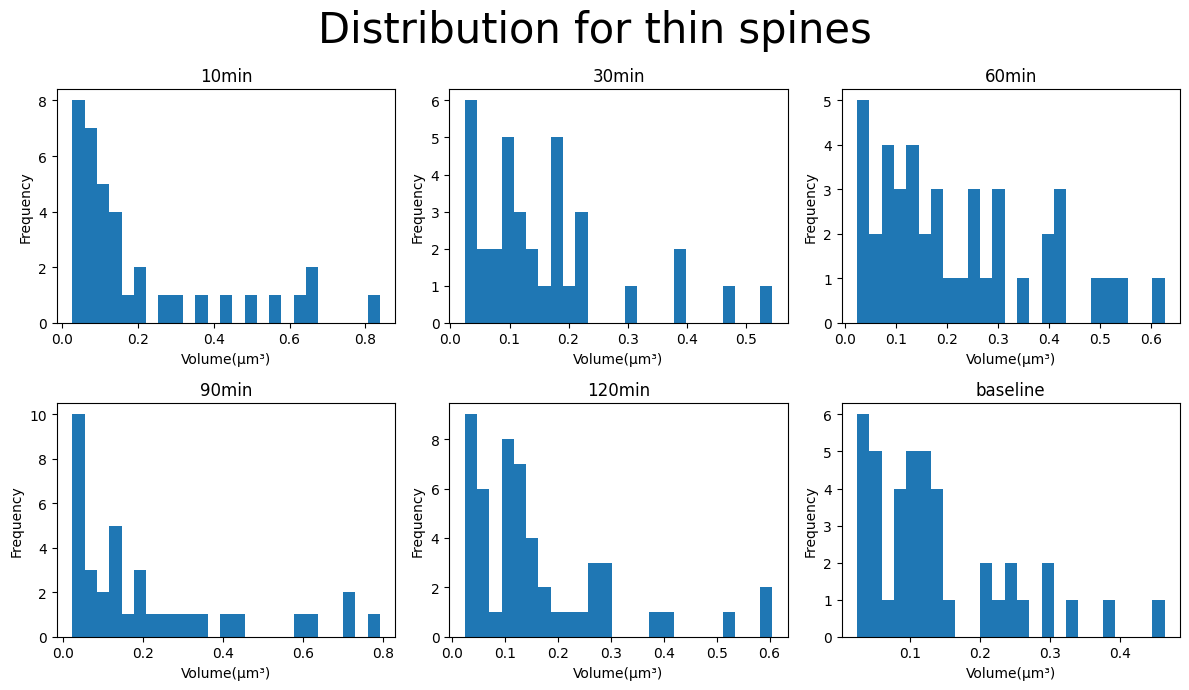

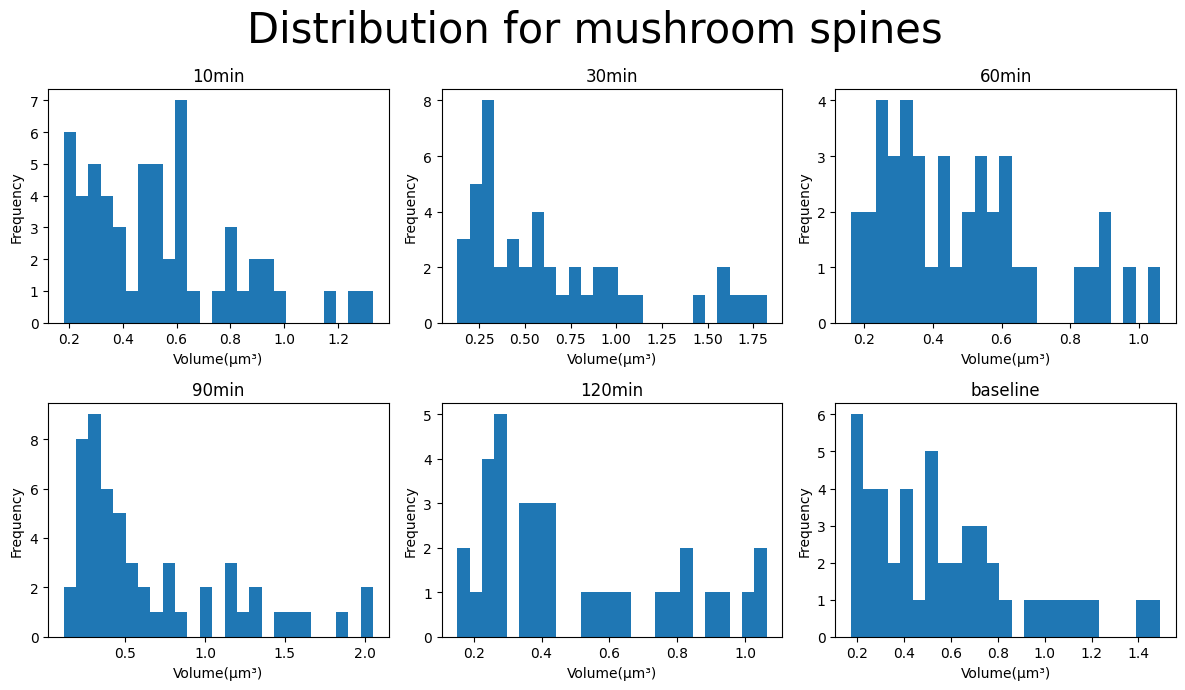

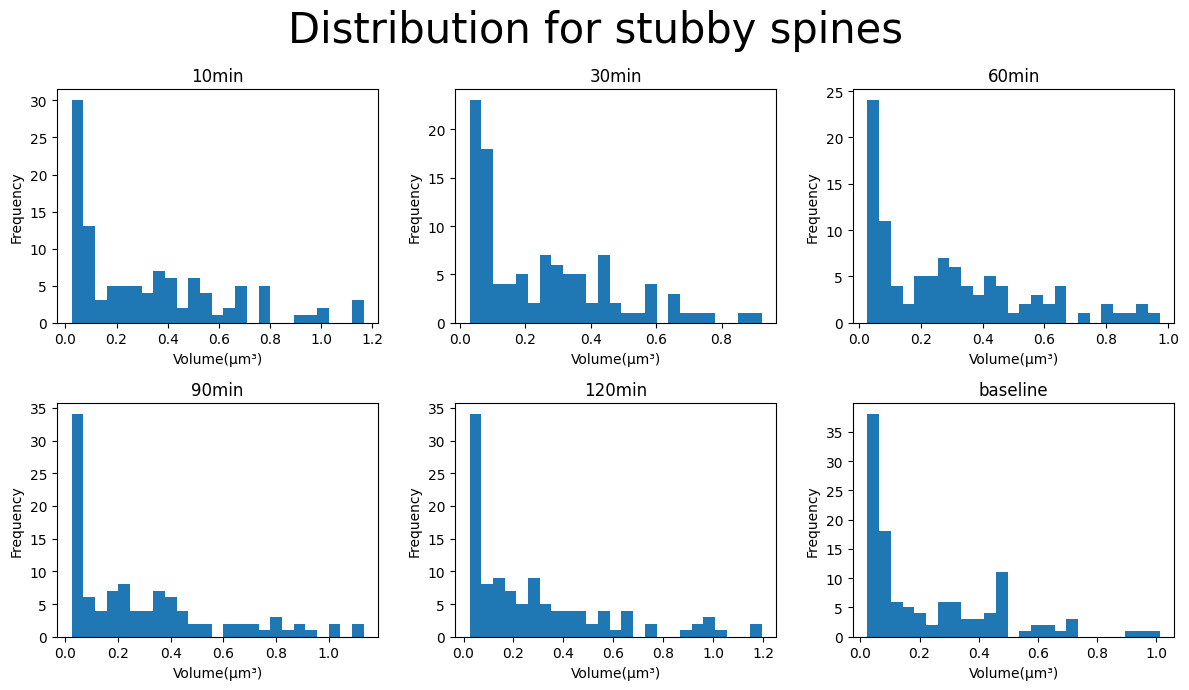

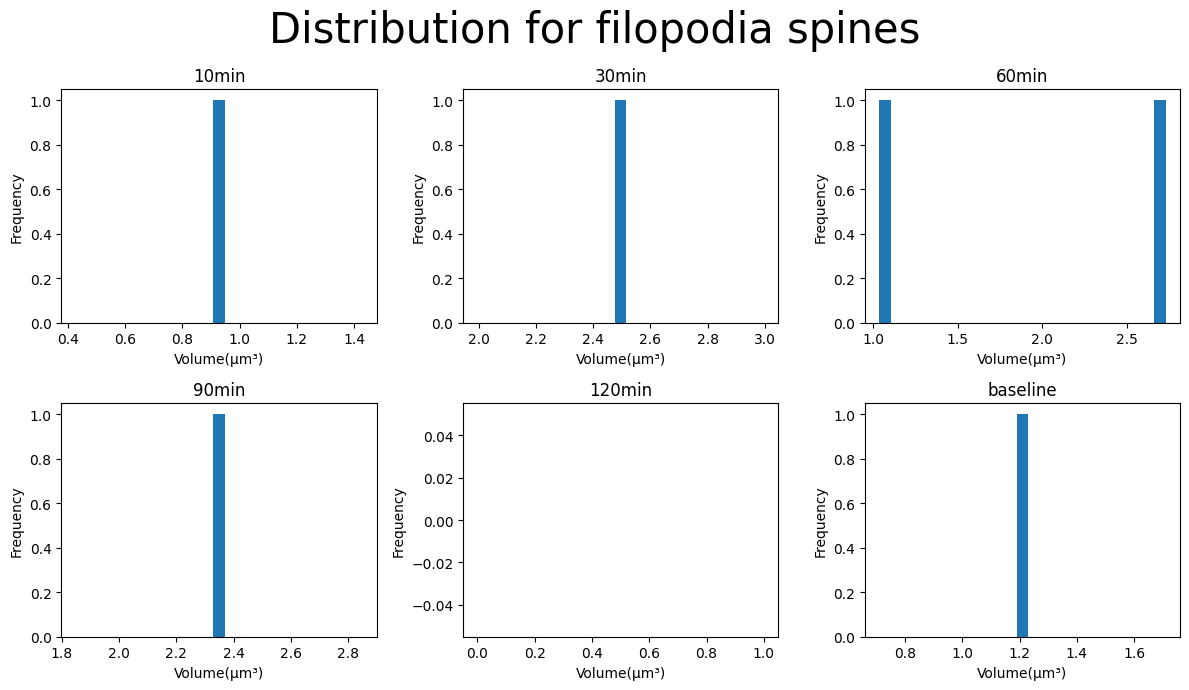

In [ ]:
show_distribution(glu_spine_dfs, 'Volume(µm³)', quantile_filter=True)

  0%|          | 0/4 [00:00<?, ?it/s]

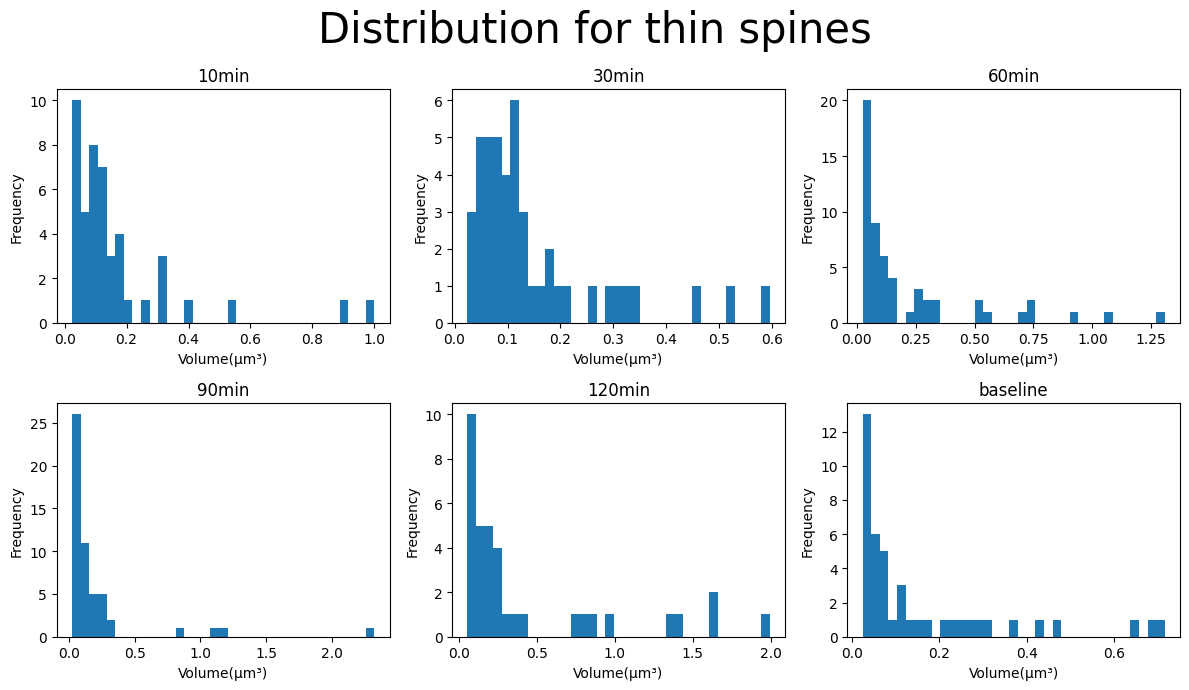

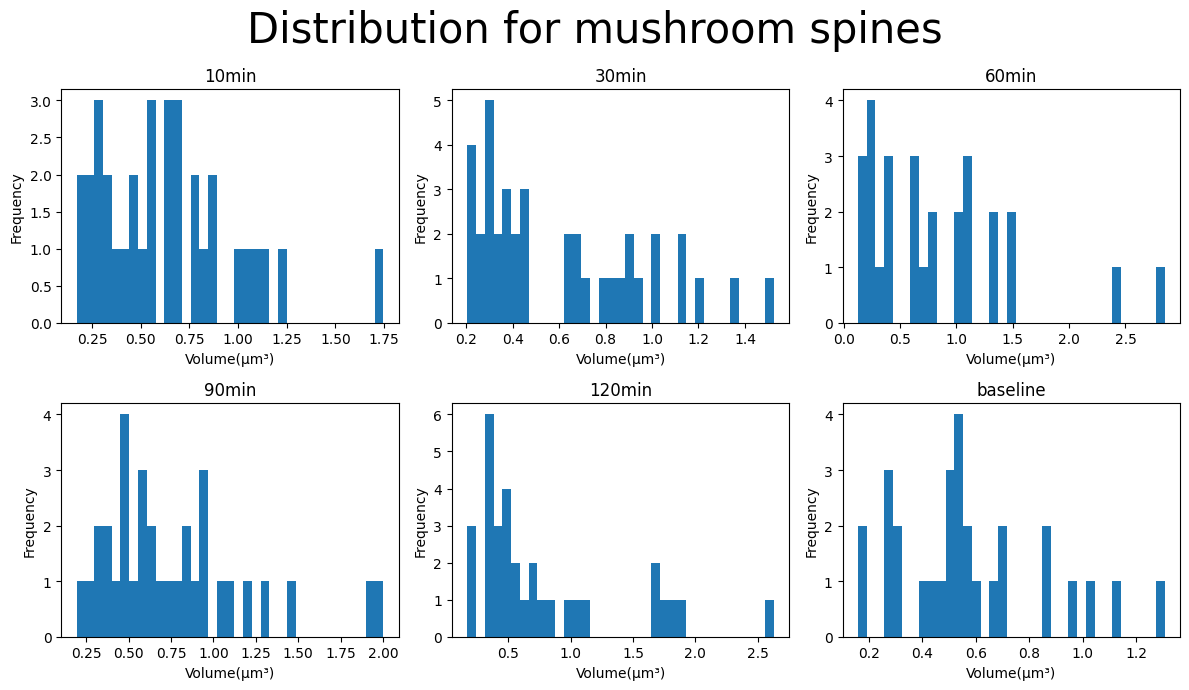

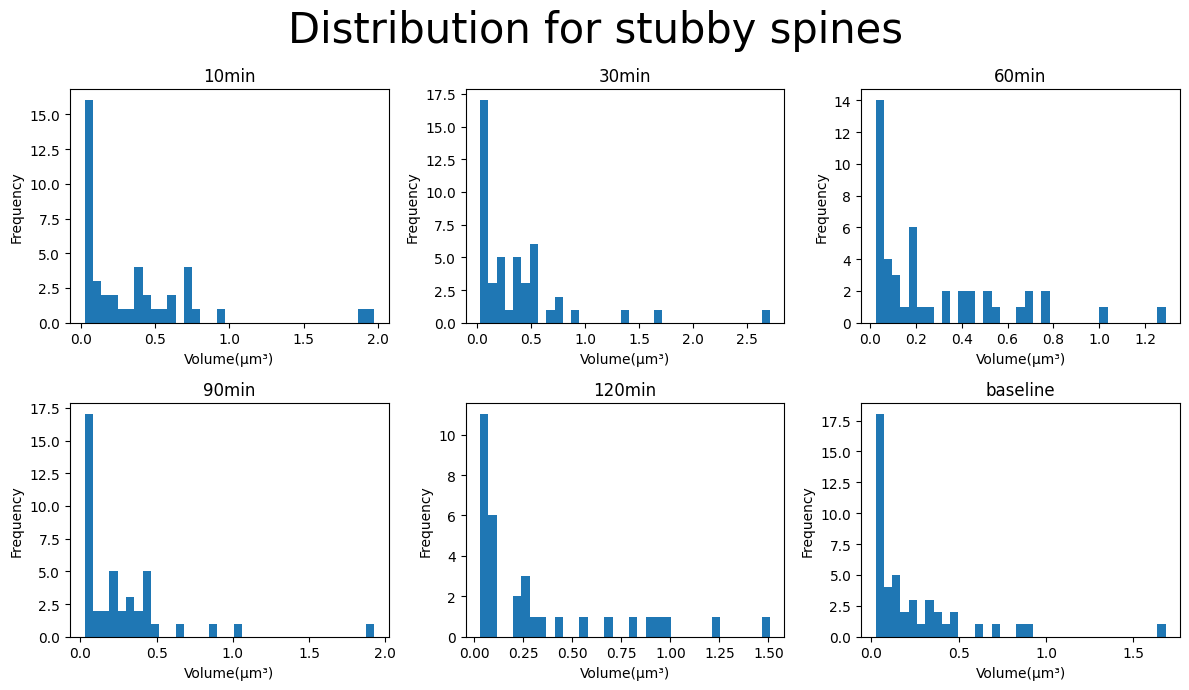

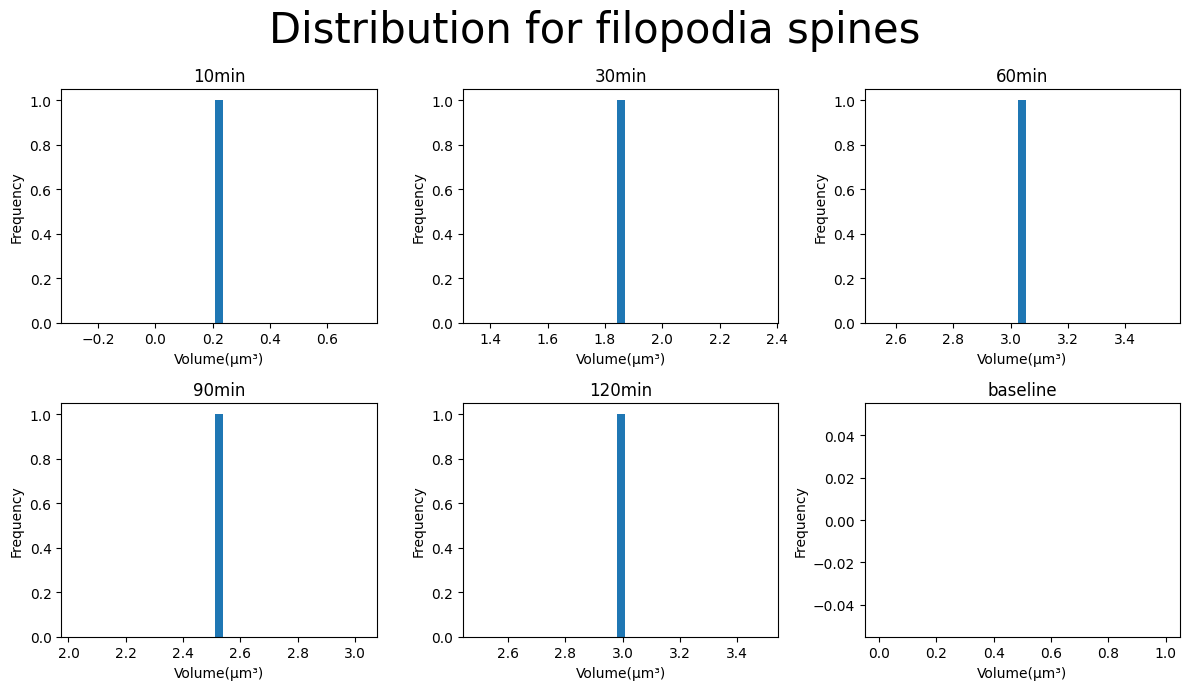

In [ ]:
show_distribution(glu_spine_dfs, 'Volume(µm³)')

In [ ]:
spine_dfs['thin']['10min'].columns.values

array(['Tree', 'Branch Order', 'Spine Type', 'Assigned Type',
       'Backbone Length(µm)', 'Backbone Length to Center(µm)',
       'Dendrite diameter at anchor (µm)', 'Volume(µm³)', 'Voxel Count',
       'Surface Area(µm²)', 'Attached?', 'Anchor Radius(µm)',
       'Plane Angle', 'Contact Area(µm²)', 'Base Coordinate',
       'Distance(µm)', 'Head Backbone Length(µm)',
       'Head Backbone Length to Center(µm)', 'Head Diameter(µm)',
       'Head Position', 'Neck Backbone Length(µm)',
       'Neck Backbone Length to Center(µm)', 'Neck Diameter(µm)',
       'ExM Neck Diameter (µm)', 'Head Diameter/Neck Diameter(µm)',
       'Backbone Length/Head Diameter(µm)', '2D Spine?'], dtype=object)

(array([29.,  9.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([0.024 , 0.1216, 0.2192, 0.3168, 0.4144, 0.512 , 0.6096, 0.7072,
        0.8048, 0.9024, 1.    ]),
 <BarContainer object of 10 artists>)

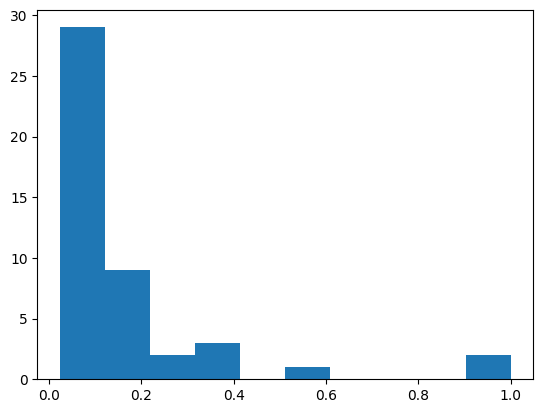

In [ ]:
plt.hist(spine_dfs['thin']['10min']['Volume(µm³)'])

## Normality test

In [ ]:
#Null hypothesis data is normal

def statistic(data):
  return scipy.stats.shapiro(data).statistic

def monte_carlo_normality_test(data):
  return scipy.stats.monte_carlo_test(data, scipy.stats.norm.rvs, statistic, alternative='two-sided')

In [ ]:
combined_dfs['10min'].columns.values

array(['Tree', 'Branch Order', 'Spine Type', 'Assigned Type',
       'Backbone Length(µm)', 'Backbone Length to Center(µm)',
       'Dendrite diameter at anchor (µm)', 'Volume(µm³)', 'Voxel Count',
       'Surface Area(µm²)', 'Attached?', 'Anchor Radius(µm)',
       'Plane Angle', 'Contact Area(µm²)', 'Base Coordinate',
       'Distance(µm)', 'Head Backbone Length(µm)',
       'Head Backbone Length to Center(µm)', 'Head Diameter(µm)',
       'Head Position', 'Neck Backbone Length(µm)',
       'Neck Backbone Length to Center(µm)', 'Neck Diameter(µm)',
       'ExM Neck Diameter (µm)', 'Head Diameter/Neck Diameter(µm)',
       'Backbone Length/Head Diameter(µm)', '2D Spine?'], dtype=object)

In [ ]:
parameters_of_interest = ['Head Diameter(µm)', 'Volume(µm³)', 'Backbone Length(µm)', 'Surface Area(µm²)']

for timepoint in tqdm(timepoints):
  for parameter in tqdm(parameters_of_interest):
    data = combined_dfs[timepoint][parameter]
    print("combined", timepoint, parameter, "p-value: "+str(monte_carlo_normality_test(list(data)).pvalue))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

combined 10min Head Diameter(µm) p-value: 0.7816
combined 10min Volume(µm³) p-value: 0.0002
combined 10min Backbone Length(µm) p-value: 0.0002
combined 10min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

combined 30min Head Diameter(µm) p-value: 0.0948
combined 30min Volume(µm³) p-value: 0.0002
combined 30min Backbone Length(µm) p-value: 0.0002
combined 30min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

combined 60min Head Diameter(µm) p-value: 0.246
combined 60min Volume(µm³) p-value: 0.0002
combined 60min Backbone Length(µm) p-value: 0.0002
combined 60min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

combined 90min Head Diameter(µm) p-value: 0.0002
combined 90min Volume(µm³) p-value: 0.0002
combined 90min Backbone Length(µm) p-value: 0.0002
combined 90min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

combined 120min Head Diameter(µm) p-value: 0.0154
combined 120min Volume(µm³) p-value: 0.0002
combined 120min Backbone Length(µm) p-value: 0.0002
combined 120min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

combined baseline Head Diameter(µm) p-value: 0.0542
combined baseline Volume(µm³) p-value: 0.0002
combined baseline Backbone Length(µm) p-value: 0.0002
combined baseline Surface Area(µm²) p-value: 0.0002


In [ ]:
parameters_of_interest = ['Head Diameter(µm)', 'Volume(µm³)', 'Backbone Length(µm)', 'Surface Area(µm²)']
for spine in tqdm(spine_dfs.keys()):
  #dont checkf or filopodia as only one instance is present
  if spine == 'filopodia':
    continue
  for timepoint in tqdm(timepoints):
    for parameter in tqdm(parameters_of_interest):
      data = spine_dfs[spine][timepoint][parameter]
      print(spine, timepoint, parameter, "p-value: "+str(monte_carlo_normality_test(list(data)).pvalue))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

thin 10min Head Diameter(µm) p-value: 0.1694
thin 10min Volume(µm³) p-value: 0.0002
thin 10min Backbone Length(µm) p-value: 0.0044
thin 10min Surface Area(µm²) p-value: 0.0004


  0%|          | 0/4 [00:00<?, ?it/s]

thin 30min Head Diameter(µm) p-value: 0.0228
thin 30min Volume(µm³) p-value: 0.0002
thin 30min Backbone Length(µm) p-value: 0.0002
thin 30min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

thin 60min Head Diameter(µm) p-value: 0.0362
thin 60min Volume(µm³) p-value: 0.0002
thin 60min Backbone Length(µm) p-value: 0.2992
thin 60min Surface Area(µm²) p-value: 0.0146


  0%|          | 0/4 [00:00<?, ?it/s]

thin 90min Head Diameter(µm) p-value: 0.5768
thin 90min Volume(µm³) p-value: 0.0002
thin 90min Backbone Length(µm) p-value: 0.0066
thin 90min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

thin 120min Head Diameter(µm) p-value: 0.1214
thin 120min Volume(µm³) p-value: 0.0002
thin 120min Backbone Length(µm) p-value: 0.0518
thin 120min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

thin baseline Head Diameter(µm) p-value: 0.0002
thin baseline Volume(µm³) p-value: 0.0002
thin baseline Backbone Length(µm) p-value: 0.0078
thin baseline Surface Area(µm²) p-value: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

mushroom 10min Head Diameter(µm) p-value: 0.0002
mushroom 10min Volume(µm³) p-value: 0.0002
mushroom 10min Backbone Length(µm) p-value: 0.0002
mushroom 10min Surface Area(µm²) p-value: 0.0004


  0%|          | 0/4 [00:00<?, ?it/s]

mushroom 30min Head Diameter(µm) p-value: 0.0028
mushroom 30min Volume(µm³) p-value: 0.0002
mushroom 30min Backbone Length(µm) p-value: 0.0012
mushroom 30min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

mushroom 60min Head Diameter(µm) p-value: 0.0232
mushroom 60min Volume(µm³) p-value: 0.0002
mushroom 60min Backbone Length(µm) p-value: 0.0008
mushroom 60min Surface Area(µm²) p-value: 0.0024


  0%|          | 0/4 [00:00<?, ?it/s]

mushroom 90min Head Diameter(µm) p-value: 0.0004
mushroom 90min Volume(µm³) p-value: 0.0002
mushroom 90min Backbone Length(µm) p-value: 0.033
mushroom 90min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

mushroom 120min Head Diameter(µm) p-value: 0.6504
mushroom 120min Volume(µm³) p-value: 0.0052
mushroom 120min Backbone Length(µm) p-value: 0.0498
mushroom 120min Surface Area(µm²) p-value: 0.0174


  0%|          | 0/4 [00:00<?, ?it/s]

mushroom baseline Head Diameter(µm) p-value: 0.0038
mushroom baseline Volume(µm³) p-value: 0.0004
mushroom baseline Backbone Length(µm) p-value: 0.0108
mushroom baseline Surface Area(µm²) p-value: 0.001


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

stubby 10min Head Diameter(µm) p-value: 0.6104
stubby 10min Volume(µm³) p-value: 0.0002
stubby 10min Backbone Length(µm) p-value: 0.003
stubby 10min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

stubby 30min Head Diameter(µm) p-value: 0.0268
stubby 30min Volume(µm³) p-value: 0.0002
stubby 30min Backbone Length(µm) p-value: 0.0036
stubby 30min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

stubby 60min Head Diameter(µm) p-value: 0.1872
stubby 60min Volume(µm³) p-value: 0.0002
stubby 60min Backbone Length(µm) p-value: 0.0042
stubby 60min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

stubby 90min Head Diameter(µm) p-value: 0.0002
stubby 90min Volume(µm³) p-value: 0.0002
stubby 90min Backbone Length(µm) p-value: 0.0034
stubby 90min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

stubby 120min Head Diameter(µm) p-value: 0.011
stubby 120min Volume(µm³) p-value: 0.0002
stubby 120min Backbone Length(µm) p-value: 0.0002
stubby 120min Surface Area(µm²) p-value: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

stubby baseline Head Diameter(µm) p-value: 0.016
stubby baseline Volume(µm³) p-value: 0.0002
stubby baseline Backbone Length(µm) p-value: 0.001
stubby baseline Surface Area(µm²) p-value: 0.0002


# Kruskal Wallis test



In [ ]:
for parameter in parameters_of_interest:
  h, p_val = scipy.stats.kruskal(*[combined_dfs[timepoint][parameter] for timepoint in timepoints])
  print(timepoint, parameter, "p-value: "+str(p_val))

baseline Head Diameter(µm) p-value: 0.5355490936972629
baseline Volume(µm³) p-value: 0.13553034515706405
baseline Backbone Length(µm) p-value: 0.3616902576548437
baseline Surface Area(µm²) p-value: 0.12673906306047894


dict_keys(['10min', '30min', '60min', '90min', '120min', 'baseline'])